## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [1]:
import pandas as pd

In [2]:
# место для кода
data = pd.read_csv("data.csv",delimiter=',')

In [3]:
# место для кода
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset='Age'), .reset_index(drop=True)`*

In [5]:
# место для кода
data.dropna(subset = ['Age'],inplace=True)
data.reset_index(drop = True,inplace=True)
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
# место для кода
data_males = data[data['Sex']=='male']
data_females = data[data['Sex']=='female']

<Figure size 1728x432 with 0 Axes>

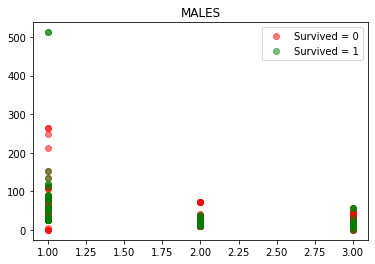

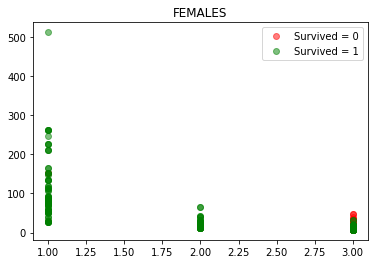

In [33]:
#Построим график 1 способом
fig = plt.figure(figsize=(24, 6))
groups = data_males.groupby('Survived')
colors = ['red','green']
fig1,ax = plt.subplots()
for tmp,color in zip(groups, colors):
    name, group = tmp
    ax.plot(group["Pclass"], group["Fare"], marker="o", linestyle="", label='Survived = ' + str(name),color = color,alpha=0.5)
    ax.set_title("MALES")
plt.legend()
groups = data_females.groupby('Survived')
fig1,ax = plt.subplots()
for tmp,color in zip(groups, colors):
    name, group = tmp
    ax.plot(group["Pclass"], group["Fare"], marker="o", linestyle="", label='Survived = ' + str(name),color = color,alpha=0.5)
    ax.set_title ("FEMALES")
plt.legend()

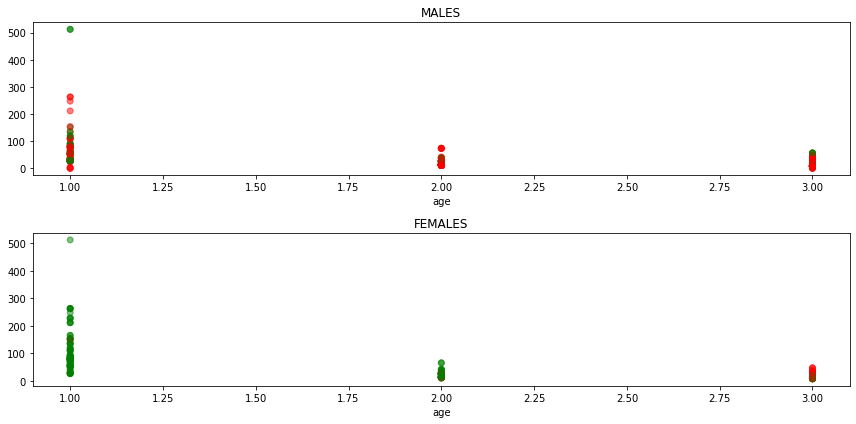

In [31]:
# А теперь 2 способом
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('customcmap',['red','green'])
#Males
fig1,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.scatter(data_males["Pclass"], data_males["Fare"],c=data_males["Survived"],cmap = cmap,alpha = 0.5)
ax1.set_title("MALES")
ax1.set_xlabel('age')
ax2.scatter(data_females["Pclass"], data_females["Fare"],c=data_females["Survived"],cmap = cmap,alpha = 0.5)
ax2.set_title("FEMALES")
ax2.set_xlabel('age')
plt.tight_layout()

### Гипотеза компактности выполняется для Pclass и Fare( для женщин - прям хорошо).
### Для Age и Fare выполняется.

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

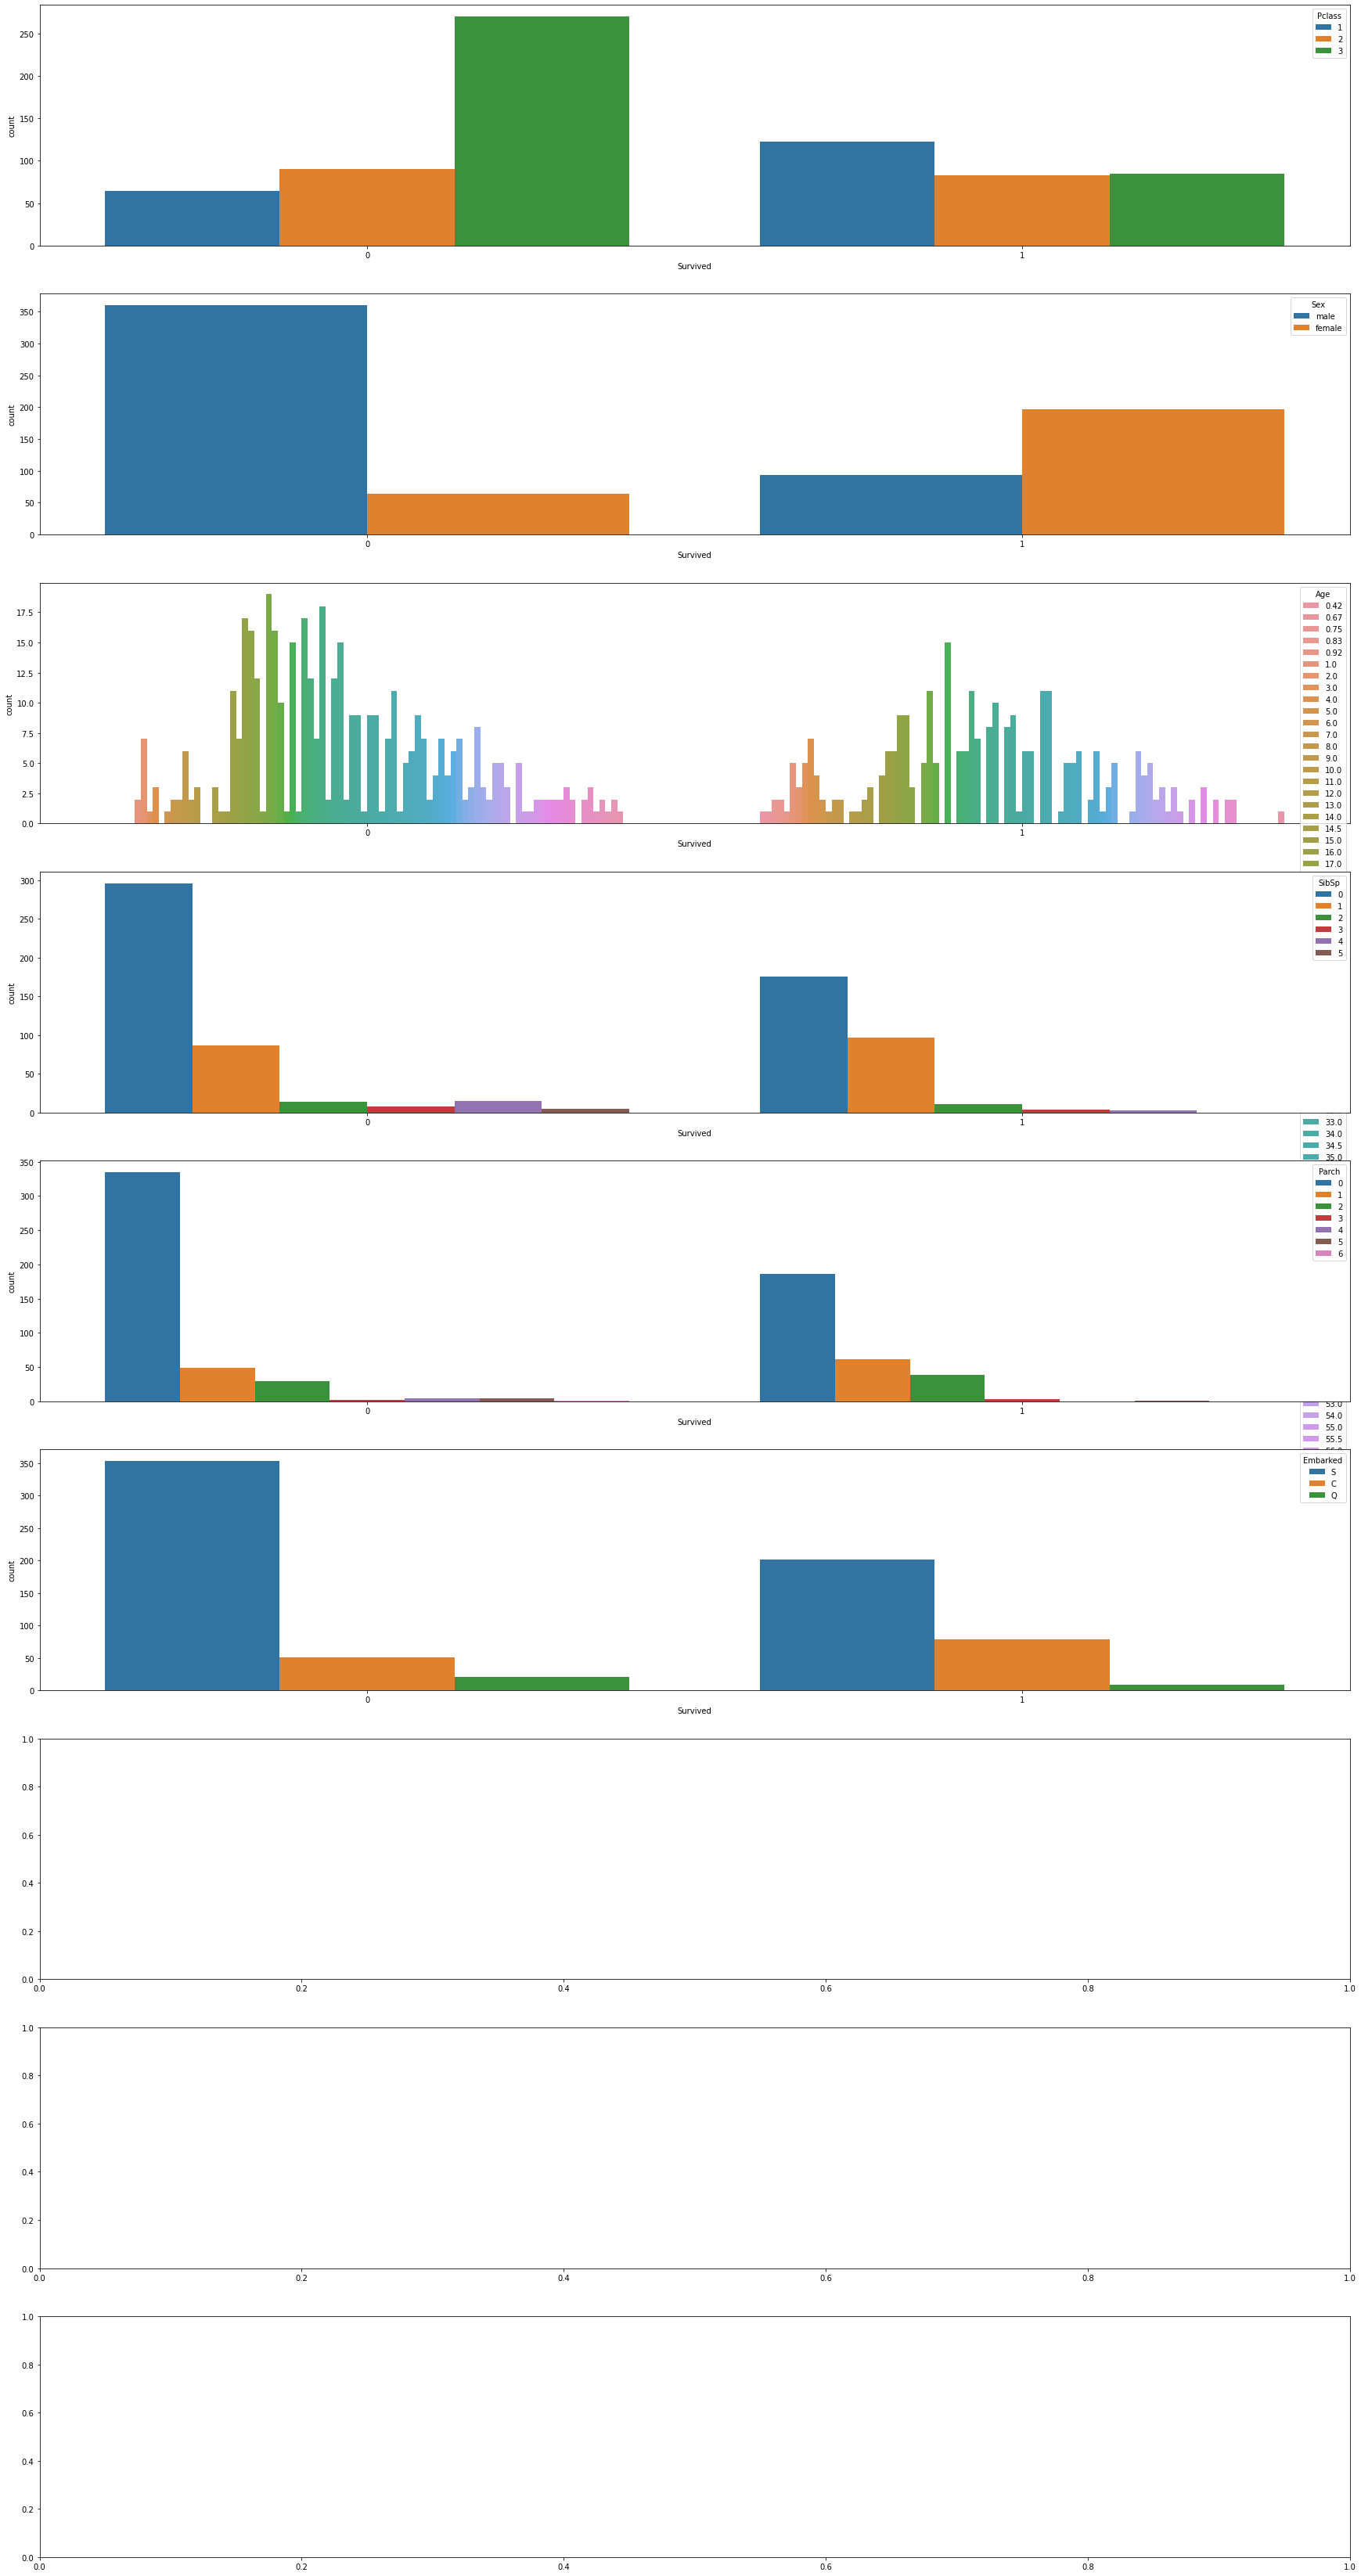

In [10]:
#Построим набор boxplot и посмотрим на распределение вероятност
import seaborn as sns
fig1,axlst = plt.subplots(9,1,figsize=(30,60))
clmns =['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Embarked']
for i,j in zip(clmns,range(len(clmns))):
    sns.countplot(x='Survived',hue = i,data=data,ax = axlst[j]) 

In [11]:
#plt.figure(figsize=(15,7))
#sns.heatmap(data.corr(),linewidths=5, annot=True)

In [12]:
'''bEST RES 81.6
def distance(a,b):
    d = 0
    d += 3*abs(a['Pclass'] - b['Pclass'])
    d += 5 * abs(a['Sex'] - b['Sex'])
    d += 0.2 * abs(a['Age'] - b['Age'])
    d += 3* abs(a['SibSp'] - b['SibSp'])
    d += 3*abs(a['Parch'] - b['Parch'])
    #d += abs(a['Fare'] - b['Fare'])
    #d += 0*a['Embarked'] != b['Embarked']
    return d*3'''
def distance(a,b):
    d = 0
    d += 3*abs(a['Pclass'] - b['Pclass'])
    d += 5 * abs(a['Sex'] - b['Sex'])
    d += 0.2 * abs(a['Age'] - b['Age'])
    d += 3* abs(a['SibSp'] - b['SibSp'])
    d += 3*abs(a['Parch'] - b['Parch'])
    #d += abs(a['Fare'] - b['Fare'])
    #d += 0*a['Embarked'] != b['Embarked']
    return d

In [13]:
#А зачем?
import numpy as np
data_new = data.copy()
data_new['Age'] = data['Age'].round()
data_new.loc[data_new['Sex'] == 'male', 'Sex'] = 0
data_new.loc[data_new['Sex'] == 'female', 'Sex'] = 1

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report
X = data_new[['Pclass', 'Age','Sex','SibSp','Parch']]
y = data_new['Survived']
res = []
for i in range(1,100):
    #print(i)
    classif = KNeighborsClassifier(n_neighbors=i,weights='distance',algorithm='kd_tree')
    classif.fit(X,y)
    pred = classif.predict(X)
    res.append(accuracy_score(y,pred))
    print(classification_report(y,pred))
print(np.argmax(res))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       424
           1       0.88      0.88      0.88       290

    accuracy                           0.90       714
   macro avg       0.90      0.90      0.90       714
weighted avg       0.90      0.90      0.90       714

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       424
           1       0.98      0.82      0.89       290

    accuracy                           0.92       714
   macro avg       0.94      0.90      0.91       714
weighted avg       0.93      0.92      0.92       714

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       424
           1       0.95      0.86      0.90       290

    accuracy                           0.92       714
   macro avg       0.93      0.91      0.92       714
weighted avg       0.93      0.92      0.92       714

              preci

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              preci

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

              preci

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       424
           1       0.98      0.84      0.91       290

    accuracy                           0.93       714
   macro avg       0.94      0.92      0.93       714
weighted avg       0.93      0.93      0.93       714

5


In [14]:
from sklearn.model_selection import cross_val_score,train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
classif = KNeighborsClassifier(n_neighbors=5)
#classif.fit(x_train,y_)
np.mean(cross_val_score(classif, X, y, cv = 20))

0.784404761904762

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [15]:
import numpy as np
import tqdm

In [16]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [17]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data_new, 5, idx)
print(accuracy/data.shape[0])

  5%|███▋                                                                             | 33/714 [00:09<03:06,  3.64it/s]


KeyboardInterrupt: 

## C++ выдает 79.972%

Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [18]:
# место для кода
def calcMargin(data, k, passenger_index):
    dists = np.zeros((data.shape[0] - 1, 2))
    i = 0
    for idx, row in data.iterrows():
        if idx != passenger_index:  #LOO метод контроля ошибки
            dists[i][0] = distance(data.loc[passenger_index], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    passenger_class = data.loc[passenger_index, 'Survived']
    passenger_class_closeness = 0
    other_class_closeness = 0
    for i in range(k):
        neighbor_class = dists[i][1]
        if neighbor_class == passenger_class:
            passenger_class_closeness += 1
        else:
            other_class_closeness += 1
    return passenger_class_closeness - other_class_closeness


In [19]:
# место для кода
margins = []
for idx, row in tqdm.tqdm(data_new.iterrows(), total=len(data_new)):
    margins.append(calcMargin(data_new, 5, idx))
margins


100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:15<00:00,  5.29it/s]


[1,
 5,
 -1,
 5,
 5,
 1,
 5,
 1,
 3,
 3,
 3,
 5,
 3,
 -5,
 3,
 5,
 1,
 3,
 -5,
 1,
 1,
 1,
 -5,
 -3,
 1,
 3,
 -1,
 1,
 3,
 1,
 -1,
 3,
 -5,
 3,
 -1,
 -1,
 5,
 3,
 5,
 3,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 -1,
 3,
 5,
 3,
 -3,
 5,
 1,
 1,
 3,
 3,
 1,
 3,
 5,
 -3,
 5,
 -1,
 -3,
 3,
 -1,
 3,
 1,
 3,
 -1,
 5,
 -3,
 3,
 5,
 5,
 -3,
 5,
 3,
 -3,
 1,
 5,
 5,
 5,
 1,
 3,
 3,
 -1,
 5,
 1,
 -3,
 3,
 5,
 3,
 1,
 1,
 5,
 3,
 5,
 5,
 -3,
 -5,
 1,
 5,
 5,
 3,
 3,
 5,
 5,
 5,
 1,
 3,
 -3,
 1,
 -3,
 3,
 3,
 1,
 -1,
 1,
 5,
 3,
 5,
 5,
 5,
 5,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 5,
 5,
 3,
 5,
 5,
 5,
 1,
 3,
 3,
 3,
 -5,
 5,
 5,
 3,
 5,
 1,
 -5,
 5,
 5,
 5,
 3,
 -1,
 5,
 5,
 3,
 5,
 -5,
 5,
 5,
 1,
 -5,
 -3,
 5,
 -3,
 1,
 -3,
 3,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 5,
 -5,
 5,
 5,
 -3,
 5,
 -5,
 5,
 3,
 5,
 -1,
 3,
 -3,
 5,
 5,
 3,
 3,
 3,
 5,
 5,
 3,
 1,
 -3,
 5,
 -3,
 5,
 1,
 5,
 5,
 -3,
 3,
 5,
 5,
 5,
 -5,
 1,
 1,
 3,
 5,
 -5,
 5,
 5,
 -5,
 5,
 1,
 5,
 1,
 5,
 -3,
 5,
 5,
 3,
 -5,
 5,
 -5,
 5,
 -5,
 1,
 5,
 5,
 3,
 -

In [20]:
len(margins)

714

In [21]:
# место для кода
margins_np = np.array(margins)
margins_np

array([ 1,  5, -1,  5,  5,  1,  5,  1,  3,  3,  3,  5,  3, -5,  3,  5,  1,
        3, -5,  1,  1,  1, -5, -3,  1,  3, -1,  1,  3,  1, -1,  3, -5,  3,
       -1, -1,  5,  3,  5,  3,  5,  3,  5,  5,  5,  5,  5, -1,  3,  5,  3,
       -3,  5,  1,  1,  3,  3,  1,  3,  5, -3,  5, -1, -3,  3, -1,  3,  1,
        3, -1,  5, -3,  3,  5,  5, -3,  5,  3, -3,  1,  5,  5,  5,  1,  3,
        3, -1,  5,  1, -3,  3,  5,  3,  1,  1,  5,  3,  5,  5, -3, -5,  1,
        5,  5,  3,  3,  5,  5,  5,  1,  3, -3,  1, -3,  3,  3,  1, -1,  1,
        5,  3,  5,  5,  5,  5,  3,  1,  3,  3,  3,  1,  3,  5,  5,  3,  5,
        5,  5,  1,  3,  3,  3, -5,  5,  5,  3,  5,  1, -5,  5,  5,  5,  3,
       -1,  5,  5,  3,  5, -5,  5,  5,  1, -5, -3,  5, -3,  1, -3,  3,  5,
        5,  5,  5,  1,  5,  5,  5, -5,  5,  5, -3,  5, -5,  5,  3,  5, -1,
        3, -3,  5,  5,  3,  3,  3,  5,  5,  3,  1, -3,  5, -3,  5,  1,  5,
        5, -3,  3,  5,  5,  5, -5,  1,  1,  3,  5, -5,  5,  5, -5,  5,  1,
        5,  1,  5, -3,  5

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [22]:
idx = np.argsort(margins_np)
idx

array([439,  22, 462, 465, 249, 396, 148, 322, 491, 498,  32, 532, 336,
       162, 616, 158, 512, 608, 287, 230, 232,  18, 100, 313, 697, 210,
       142, 431, 182, 218, 215, 444,  13, 177, 451, 228, 682, 368, 332,
       326, 525, 347,  60,  63, 490,  75, 378, 385,  78, 113,  89, 111,
       399, 405, 198, 432,  99,  71, 537,  51, 553, 634, 547, 165, 167,
       240,  23, 264, 652, 180, 680, 188, 205, 200, 706, 224, 163, 413,
       271, 557, 306, 591, 298, 301, 406, 299, 186, 402, 338, 295, 153,
       349, 237, 361, 252, 390, 258, 365, 290, 280, 117, 269, 386, 713,
       521,  69, 644,  26,  65,  62, 535, 641, 657,  30, 562,  34,  35,
       623, 613, 576,  47, 626, 663, 595,  86,   2, 685, 694, 500, 503,
       516, 211, 693, 658, 617, 700, 202, 274, 612, 695, 267, 636, 686,
       642, 683, 643, 669, 233, 596, 647, 220, 650, 222, 212, 423, 573,
       586, 364, 513, 510, 382, 497, 475, 392, 473, 458, 450, 400, 449,
       440, 437, 430, 363, 518, 712, 348, 296, 429, 300, 566, 30

In [26]:
print('Белые вороны (аномалии)')
sel = data_new.loc[idx[:15],]
sel

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
439,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",0,22.0,0,0,2620,7.2250,NaN,C
22,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",1,38.0,1,5,347077,31.3875,NaN,S
462,584,0,1,"Ross, Mr. John Hugo",0,36.0,0,0,13049,40.1250,A10,C
465,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",0,60.0,1,1,13567,79.2000,B41,C
249,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",1,26.0,1,1,250651,26.0000,NaN,S
396,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.0,1,2,113781,151.5500,C22 C26,S
148,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",0,45.0,0,0,111428,26.5500,NaN,S
322,401,1,3,"Niskanen, Mr. Juha",0,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S
491,623,1,3,"Nakid, Mr. Sahid",0,20.0,1,1,2653,15.7417,NaN,C
498,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",0,80.0,0,0,27042,30.0000,A23,S


In [27]:
print('Эталоны (характерные объекты)')
sel = data_new.loc[idx[-15:],]
sel

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
102,131,0,3,"Drazenoic, Mr. Jozef",0,33.0,0,0,349241,7.8958,NaN,C
103,132,0,3,"Coelho, Mr. Domingos Fernandeo",0,20.0,0,0,SOTON/O.Q. 3101307,7.0500,NaN,S
428,541,1,1,"Crosby, Miss. Harriet R",1,36.0,0,2,WE/P 5735,71.0000,B22,S
427,540,1,1,"Frolicher, Miss. Hedwig Margaritha",1,22.0,0,2,13568,49.5000,B39,C
426,538,1,1,"LeRoy, Miss. Bertha",1,30.0,0,0,PC 17761,106.4250,NaN,C
424,536,1,2,"Hart, Miss. Eva Miriam",1,7.0,0,2,F.C.C. 13529,26.2500,NaN,S
421,531,1,2,"Quick, Miss. Phyllis May",1,2.0,1,1,26360,26.0000,NaN,S
416,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",1,44.0,0,1,111361,57.9792,B18,C
415,522,0,3,"Vovk, Mr. Janko",0,22.0,0,0,349252,7.8958,NaN,S
414,521,1,1,"Perreault, Miss. Anne",1,30.0,0,0,12749,93.5000,B73,S


# Выводы
Можно предположить, что эталонны следующие обьекты:
Среди выживших - женщины из кают 1 и 2 класса возрастом менее 30 лет
Образцовый труп - мужчины из кают 2 и 3 класса, возрастом около 25 лет